In [1]:
import os
import glob
import random
import itertools

In [2]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

In [3]:
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

In [4]:
import sys
print(sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [5]:
# CUDA stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


In [6]:
use_cuda

True

# use cycleGAN

## what to use?

for generator, use encoder/transformer/decoder combo

for discriminator, use patchGAN

# making generator

we gotta make residual blocks

In [7]:
# def activation_func(activation):
#     return  nn.ModuleDict([
#         ['relu', nn.ReLU(inplace=True)],
#         ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
#         ['selu', nn.SELU(inplace=True)],
#         ['none', nn.Identity()]
#     ])[activation]

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_fn):
        super(ResidualBlock, self).__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activation_fn = activation_fn
        self.shortcut = nn.Identity()
        
        
        
    def forward(self, x):
        residual = x
        if self.apply_shortcut:
            residual = self.shortcut(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def apply_shortcut(self):
        return self.in_channels != self.out_channels
        
        

In [9]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, activation_fn):
        super(ResNetResidualBlock, self).__init__(in_channels, 
                                                       out_channels, 
                                                       *args,
                                                       **kwargs)
        
        
        
        

In [10]:
class ResNetBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResNetBlock, self).__init__()
        # input and output dim will be the same for our uses
#         self.reflect1 = nn.ReflectionPad2d(1)
#         self.reflect2 = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(input_dim, input_dim, kernel_size=3, padding=1, bias=True)
        self.norm1 = nn.InstanceNorm2d(input_dim)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        
        self.conv2 = nn.Conv2d(input_dim, input_dim, kernel_size=3, padding=1, bias=True)
        self.norm2 = nn.InstanceNorm2d(input_dim)
        
#         self.relu_final = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        
    def forward(self, x):
#         x_new = self.reflect1(x)
        x_new = self.conv1(x)
        x_new = self.norm1(x_new)
        x_new = self.relu1(x_new)
#         x_new = self.reflect2(x_new)
        x_new = self.conv2(x_new)
        x_new = self.norm2(x_new)
        out = x + x_new
#         out = self.relu_final(x_new)
        return out

In [11]:
class CycleGenerator(nn.Module):
    def __init__(self):
        super(CycleGenerator, self).__init__()
#         self.activations = nn.ModuleDict({
#         'relu', nn.ReLU(inplace=True),
#         'leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True),
#         'selu', nn.SELU(inplace=True),
#         'none', nn.Identity()})
        
        # do we need this many filter channels 
        # if we're doing a 1 channel image rather than 3 channel?
        
#         #encoder section
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
#                                kernel_size=(7, 7), padding=0)
#         self.conv2 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1), stride=2)
#         self.conv3 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1), stride=2)
        
#         # in the transformer
#         self.conv4 = nn.Conv2d(1, 128, (3, 3), padding=(1, 1), stride=2)
#         https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(in_channels=1, out_channels=64,
                           kernel_size=7, padding=0,
                           bias=True),
                 nn.InstanceNorm2d(64),
                 nn.LeakyReLU(negative_slope=0.01, inplace=True)]
    
        #downsampling layers
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(in_channels=64*mult, out_channels=64*mult*2,
                           kernel_size=3, stride=2, padding=1,
                           bias=True),
                      nn.InstanceNorm2d(64*mult*2),
                      nn.LeakyReLU(negative_slope=0.01, inplace=True)]
            
        # resnet blocks layer
        num_resnet_blocks = 6
        for i in range(num_resnet_blocks):
            model += [ResNetBlock(64*mult*2)]
            
        # upsampling layers
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(in_channels=64*mult, out_channels=int(64*mult/2),
                           kernel_size=3, stride=2, padding=1, output_padding=1,
                           bias=True),
                      nn.InstanceNorm2d(int(64*mult/2)),
                      nn.LeakyReLU(negative_slope=0.01, inplace=True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(64, 1, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        
        self.model = nn.Sequential(*model)
        
            
        
    def forward(self, x):
        return self.model(x)
        

In [12]:
class CycleDiscriminator(nn.Module):
    def __init__(self):
        super(CycleDiscriminator, self).__init__()
        #https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py
        
        model = [
#             nn.ReflectionPad2d(16),
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, True)]
        n_layers = 3 + 1
        
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8) # 2^n
            model += [
                nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(64*nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n, 8) # 2^n
        model += [
            nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, kernel_size=3, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(64*nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
#         model += [nn.ZeroPad2d((1, 0, 1, 0))]
        model += [nn.Conv2d(64*nf_mult, 1, kernel_size=3, stride=1, padding=1)] # 1 channel prediction map
        self.model = nn.Sequential(*model)
#         print(self.model)
#         self.poo = nn.Conv2d(64*nf_mult, 1, kernel_size=3, stride=1, padding=1)
#         print(self.model)
    def forward(self, x):
        out = self.model(x)
#         print("--------before final layer--------")
#         print(out.shape)
#         out = self.poo(out)
#         print("-------after---------")
#         print(out.shape)
#         print("---------DEBUG FINISH--------")
        # get average classification of pixel reps of patches
#         print(F.avg_pool2d(out, out.size()[2:]))
#         print(F.avg_pool2d(out, out.size()[2:]).shape)
#         print(torch.squeeze(F.avg_pool2d(out, out.size()[2:])).shape)
        return torch.squeeze(F.avg_pool2d(out, out.shape[2:]))
#         return out

In [13]:
model = [nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, True)]
n_layers = 4
        
nf_mult = 1
nf_mult_prev = 1
for n in range(1, n_layers):
    nf_mult_prev = nf_mult
    nf_mult = min(2 ** n, 8) # 2^n
    model += [
        nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, kernel_size=4, stride=2, padding=1, bias=True),
        nn.InstanceNorm2d(64*nf_mult),
        nn.LeakyReLU(0.2, True)
    ]
nf_mult_prev = nf_mult
nf_mult = min(2 ** n, 8) # 2^n
model += [
    nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, kernel_size=4, stride=1, padding=1, bias=True),
    nn.InstanceNorm2d(64*nf_mult),
    nn.LeakyReLU(0.2, True)
]
print(64 * n)

model += [nn.Conv2d(64*nf_mult, 1, kernel_size=4, stride=1, padding=1)] # 1 channel prediction map
model

192


[Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 LeakyReLU(negative_slope=0.2, inplace=True),
 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
 LeakyReLU(negative_slope=0.2, inplace=True),
 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
 LeakyReLU(negative_slope=0.2, inplace=True),
 Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
 LeakyReLU(negative_slope=0.2, inplace=True),
 Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
 LeakyReLU(negative_slope=0.2, inplace=True),
 Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))]

In [14]:
# from collections import OrderedDict

In [15]:
# def summary(input_size, model):
#     def register_hook(module):
#         def hook(module, input, output):
#             class_name = str(module.__class__).split('.')[-1].split("'")[0]
#             module_idx = len(summary)

#             m_key = '%s-%i' % (class_name, module_idx + 1)
#             summary[m_key] = OrderedDict()
#             summary[m_key]['input_shape'] = list(input[0].size())
#             summary[m_key]['input_shape'][0] = -1
#             summary[m_key]['output_shape'] = list(output.size())
#             summary[m_key]['output_shape'][0] = -1

#             params = 0
#             if hasattr(module, 'weight'):
#                 params += torch.prod(torch.LongTensor(list(module.weight.size())))
#                 if module.weight.requires_grad:
#                     summary[m_key]['trainable'] = True
#                 else:
#                     summary[m_key]['trainable'] = False
#             if hasattr(module, 'bias'):
#                 params += torch.prod(torch.LongTensor(list(module.bias.size())))
#             summary[m_key]['nb_params'] = params

#         if not isinstance(module, nn.Sequential) and \
#                 not isinstance(module, nn.ModuleList) and \
#                 not (module == model):
#             hooks.append(module.register_forward_hook(hook))

#     # check if there are multiple inputs to the network
#     if isinstance(input_size[0], (list, tuple)):
#         x = [Variable(torch.rand(1, *in_size)) for in_size in input_size]
#     else:
#         x = Variable(torch.rand(1, *input_size))

#     # create properties
#     summary = OrderedDict()
#     hooks = []
#     # register hook
#     model.apply(register_hook)
#     # make a forward pass
#     model.forward(x)
#     # remove these hooks
#     for h in hooks:
#         h.remove()

#     return summary

In [16]:
# model.forward()

In [17]:

# https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/utils.py
class ImageBuffer():
    def __init__(self, max_size=50):
        assert max_size > 0
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        print('===========================================================START DEBUG LOOP FOR PUSH AND POP')
        to_return = []
        for elem in data:
            print("=======================================================================ANOTHER ELEM")
            elem = torch.unsqueeze(elem, 0)
            if len(self.data) < self.max_size:
                print('=============================================================MAX SIZE NOT REACHED')
                self.data.append(elem)
                to_return.append(elem)
            else:
                # half chance to randomly pick a data pt from history, 
                # otherwise just pick the selected data pt and don't add to history 
                if random.uniform(0, 1) < 0.5:
                    idx = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = elem
                else:
                    to_return.append(elem)
        print('=========================================================================TO_RETURN')
        print(to_return)
        print('\n\n\n\n===================================================================================')
        print(torch.cat(to_return))
        print(torch.cat(to_return).shape)
        return torch.cat(to_return)
                    
                

In [18]:
class DocumentsDataset(Dataset):
    def __init__(self, dirty_dir, clean_dir, transform=None, aligned=False):
        super(DocumentsDataset, self).__init__()
        self.dirty_arr = glob.glob(os.path.join(dirty_dir, '*.png'))
        self.clean_arr = glob.glob(os.path.join(clean_dir, '*.png'))
        self.dirty_dir = dirty_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.aligned = aligned
    
    def __len__(self):
        # could be dirty arr or clean arr, shouldn't matter
        return max(len(self.dirty_arr), len(self.clean_arr))
    
    def __getitem__(self, index):
        """Generate one sample of data, based on dirty data"""
        
        # grab a random index for each. the modulus allows overflow, and makes it unaligned if overflow
        idx_dirty = index % len(self.dirty_arr)
        if self.aligned:
            idx_clean = index % len(self.clean_arr)
        else:
            idx_clean = random.randint(0, len(self.clean_arr) - 1)
        
        dirty_img_name = os.path.basename(self.dirty_arr[idx_dirty])
        clean_img_name = os.path.basename(self.clean_arr[idx_clean])
        dirty_path = os.path.join(self.dirty_dir, dirty_img_name)
        clean_path = os.path.join(self.clean_dir, clean_img_name)
        transformed_dirty = Image.open(dirty_path)
        transformed_clean = Image.open(clean_path)
        
        if self.transform:
            # notice how with each transform, they are each independent.
            # this allows the random crop and flips to be different with each img
            # because cyclegan is meant for unpaired it won't matter
            transformed_dirty = self.transform(transformed_dirty)
            transformed_clean = self.transform(transformed_clean)
            
        # because the image is single channel, we need to unsqueeze so it shows that single channel.
#         transformed_dirty = torch.unsqueeze(transformed_dirty, dim=0)
#         transformed_clean = torch.unsqueeze(transformed_clean, dim=0)
        
        return {'dirty': transformed_dirty, 'clean': transformed_clean}

In [19]:
arr = Image.open('./data/train/101.png')

In [20]:
np.array(arr, dtype=np.float32).shape

(420, 540)

In [21]:
test_arr = glob.glob(os.path.join('./data/train', '*.png'))
test_arr


['./data/train/36.png',
 './data/train/140.png',
 './data/train/105.png',
 './data/train/56.png',
 './data/train/114.png',
 './data/train/17.png',
 './data/train/179.png',
 './data/train/2.png',
 './data/train/68.png',
 './data/train/186.png',
 './data/train/90.png',
 './data/train/80.png',
 './data/train/162.png',
 './data/train/96.png',
 './data/train/21.png',
 './data/train/78.png',
 './data/train/26.png',
 './data/train/81.png',
 './data/train/198.png',
 './data/train/119.png',
 './data/train/149.png',
 './data/train/108.png',
 './data/train/188.png',
 './data/train/180.png',
 './data/train/194.png',
 './data/train/177.png',
 './data/train/14.png',
 './data/train/164.png',
 './data/train/135.png',
 './data/train/171.png',
 './data/train/144.png',
 './data/train/146.png',
 './data/train/185.png',
 './data/train/200.png',
 './data/train/42.png',
 './data/train/35.png',
 './data/train/66.png',
 './data/train/113.png',
 './data/train/59.png',
 './data/train/89.png',
 './data/train/173.

In [22]:
os.path.abspath(test_arr[2])

'/home/jimzers/Documents/denoising-docs/data/train/105.png'

In [23]:
img_h = 256
img_w = 256
# params = {'batch_size': 16,
#           'shuffle': True,
#           'num_workers': 10}
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 10}
trans = transforms.Compose([
    transforms.Resize((int(img_h*1.12),int(img_w*1.12)), Image.BICUBIC), # make it bigger so random crop is more random
    transforms.RandomCrop((img_h, img_w)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # mean, std of each channel. can provice a tuple for 3 dim images
])
training_set = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/', transform=trans)
training_generator = DataLoader(training_set, **params)

In [24]:
training_generator


In [25]:
dataiter = iter(training_generator)
lol = dataiter.next()

In [26]:
cv2.imread('./data/train/15.png', 0).shape

(258, 540)

In [27]:
lol['dirty'].data.shape

torch.Size([4, 1, 256, 256])

In [28]:
lol['dirty'].shape

torch.Size([4, 1, 256, 256])

In [29]:
b = lol['dirty'][0].numpy()[0]
b

array([[ 0.7647059 ,  0.78039217,  0.8117647 , ...,  0.21568632,
        -0.1607843 ,  0.8980392 ],
       [ 0.7647059 ,  0.77254903,  0.8039216 , ...,  0.1686275 ,
        -0.15294117,  0.8980392 ],
       [ 0.79607844,  0.7882353 ,  0.7647059 , ...,  0.20784318,
        -0.1372549 ,  0.90588236],
       ...,
       [ 0.7647059 ,  0.05098045, -0.44313723, ..., -0.6156863 ,
         0.26274514,  0.41176474],
       [ 0.73333335,  0.60784316, -0.02745098, ..., -0.49019605,
         0.27058828,  0.38823533],
       [ 0.67058825,  0.00392163,  0.6392157 , ..., -0.14509803,
         0.24705887,  0.427451  ]], dtype=float32)

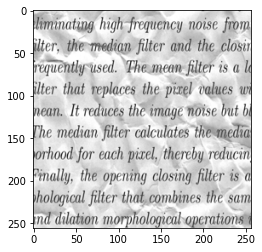

In [30]:
plt.imshow(lol['dirty'][2].numpy()[0], cmap='gray')

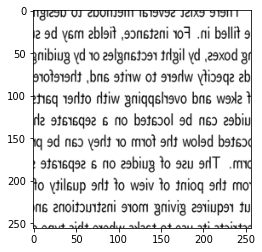

In [31]:
plt.imshow(lol['clean'][2].numpy()[0], cmap='gray')

In [32]:
# TODO: unsqueeze the resulting image

In [33]:
def custom_lr(n_epochs, start_epoch, decay_epoch):
    '''
    returns a function that calcs learning rate for given epoch.
    n_epochs (int) -> number of planned epochs
    start_epoch -> the epoch number that the optimizer starts on
    decay_epoch -> the epoch number to start decaying at
    '''
    return lambda epoch: 1.0 - max(0, epoch + start_epoch - decay_epoch)/(n_epochs - decay_epoch)

In [34]:
for i in range(1, 4):
    print(i)

1
2
3


In [35]:
# hyperparams
n_epochs = 200
decay_epoch = 100 # default 100
lr = 0.0002 # default 0.0002
batch_size = 4 # plz adjust
# if resuming change this
starting_epoch = 0



In [36]:
# class CycleGAN(nn.Module):
#     def __init__(self):
#         '''
#         init the cycle gan. add the loss functions
#         add the models.
#         add img buffer
#         '''
        
#         #start with models
#         generator_clean = CycleGenerator() # dirty to clean
#         discriminator_clean = CycleDiscriminator() # clean is fake/real
        
#         generator_dirty = CycleGenerator() # clean to dirty
#         discriminator_clean = CycleDiscriminator() # dirty is fake/real
        
#         # turn on cuda
#         if use_cuda:
#             generator_clean.cuda()
#             discriminator_clean.cuda()
#             generator_dirty.cuda()
#             discriminator_dirty.cuda()
        
#         # init weights for stuff, apparently kaiming is better for conv nets?
#         generator_clean.apply(nn.init.kaiming_uniform)
#         discriminator_clean.apply(nn.init.kaiming_uniform)
#         generator_dirty.apply(nn.init.kaiming_uniform)
#         discriminator_dirty.apply(nn.init.kaiming_uniform)
        
#         # loss fns
#         # also can add identity loss mentioned, but it is mainly for color channels. it is l1 loss as well
#         loss_gan = nn.MSELoss()
#         loss_cycle = nn.L1Loss()
#         loss_identity = nn.L1Loss()
        
#         # optimizers
#         # use default recommended values for first and second momentums on gradient accumulation
#         opt_generators = optim.Adam(itertools.chain(generator_clean.parameters(),
#                                                    generator_dirty.parameters()),
#                                    lr=lr, betas=(0.5, 0.999))
#         opt_d_clean = optim.Adam(discriminator_clean.parameters(), lr=lr, betas=(0.5, 0.999))
#         opt_d_dirty = optim.Adam(discriminator_dirty.parameters(), lr=lr, betas=(0.5, 0.999))
        
#         scheduler_g = optim.lr_scheduler.LambdaLR(opt_generators, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))
#         scheduler_d_clean = optim.lr_scheduler.LambdaLR(opt_d_clean, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))
#         scheduler_d_dirty = optim.lr_scheduler.LambdaLR(opt_d_dirty, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))
        
# #         Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
        
        
        
#         # image buffers for gans
#         fake_img_buffer_clean = ImageBuffer()
#         fake_img_buffer_dirty = ImageBuffer()
        
        
        
        
        

In [37]:
# taken from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py

init_type = 'kaiming'
def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                nn.init.kaiming_uniform_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)
        # what do i do for instance norm plzzzz

# training cycle

## generators

generate both fake images for both mappings from clean / dirty

also identity loss, where you put a dirty image as input to a clean to dirty and even though you gave it the target domain instead of input domain, it should still make a target domain that looks the same.

(don't forget the gan loss for both generators!)

also get cycle loss for both ways

finally do total loss for both generators combined

## discriminators

the params for each are split but more or less the process is the same

get loss on real stuff, fake stuff, and combined of both losses (averaged)

also we can use the image buffer here to lower model oscillation




In [38]:
torch.ones(batch_size).type()

'torch.FloatTensor'

In [39]:
torch.zeros(batch_size).type()

'torch.FloatTensor'

In [40]:
batch_size

4

In [41]:
# model.forward()


In [42]:
#start with models
generator_clean = CycleGenerator().to(device) # dirty to clean
discriminator_clean = CycleDiscriminator().to(device) # clean is fake/real - close to 1 if real. close to 0 if fake

generator_dirty = CycleGenerator().to(device) # clean to dirty
discriminator_dirty = CycleDiscriminator().to(device) # dirty is fake/real

# # turn on cuda
# if use_cuda:
#     generator_clean.cuda()
#     discriminator_clean.cuda()
#     generator_dirty.cuda()
#     discriminator_dirty.cuda()

# init weights for stuff, apparently kaiming is better for conv nets?
generator_clean.apply(init_func)
discriminator_clean.apply(init_func)
generator_dirty.apply(init_func)
discriminator_dirty.apply(init_func)

# loss fns
# also can add identity loss mentioned, but it is mainly for color channels. it is l1 loss as well
loss_gan = nn.MSELoss()
loss_cycle = nn.L1Loss()
loss_identity = nn.L1Loss()

loss_gan_mult = torch.ones(batch_size).to(device) * 5.0
loss_cycle_mult = torch.ones(batch_size).to(device) * 10.0
loss_identity_mult = torch.ones(batch_size).to(device)

# optimizers
# use default recommended values for first and second momentums on gradient accumulation
opt_generators = optim.Adam(itertools.chain(generator_clean.parameters(),
                                           generator_dirty.parameters()),
                           lr=lr, betas=(0.5, 0.999))
opt_d_clean = optim.Adam(discriminator_clean.parameters(), lr=lr, betas=(0.5, 0.999))
opt_d_dirty = optim.Adam(discriminator_dirty.parameters(), lr=lr, betas=(0.5, 0.999))

scheduler_g = optim.lr_scheduler.LambdaLR(opt_generators, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))
scheduler_d_clean = optim.lr_scheduler.LambdaLR(opt_d_clean, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))
scheduler_d_dirty = optim.lr_scheduler.LambdaLR(opt_d_dirty, lr_lambda=custom_lr(n_epochs, starting_epoch, decay_epoch))


# image buffers for gans
fake_img_buffer_clean = ImageBuffer()
fake_img_buffer_dirty = ImageBuffer()

# true / false arrays
true_arr = torch.ones(batch_size).cuda()
false_arr = torch.zeros(batch_size).cuda()


for epoch in range(starting_epoch, n_epochs):
    for i, batch in enumerate(training_generator):
        print('we are on step {0} for epoch {1}'.format(i, epoch))
        real_dirty_imgs = batch['dirty']
        real_clean_imgs = batch['clean']
        print(real_dirty_imgs.shape)
        if use_cuda:
            real_dirty_imgs = real_dirty_imgs.cuda()
            real_clean_imgs = real_clean_imgs.cuda()
        # generators
        opt_generators.zero_grad()
        
        # get results
        fake_dirty = generator_dirty(real_clean_imgs)
        fake_clean = generator_clean(real_dirty_imgs)
        
        # discriminators try to guess
        print('debug step')
        print(fake_dirty.shape)
        guess_fake_dirty = discriminator_dirty(fake_dirty)
        guess_fake_clean = discriminator_clean(fake_clean)
        print('guess_fake_dirty shape')
        print(guess_fake_dirty.shape)
        print(guess_fake_dirty[0])
        print('true arr shape')
        print(true_arr.shape)
        print(true_arr[0])
        
        # generator loss
        loss_generator_dirty = loss_gan(guess_fake_dirty, true_arr) * loss_gan_mult
        loss_generator_clean = loss_gan(guess_fake_clean, true_arr) * loss_gan_mult
        
        # cycle loss
        cycled_dirty = generator_dirty(fake_clean)
        cycled_clean = generator_clean(fake_dirty)
        
        loss_cycled_dirty = loss_cycle(cycled_dirty, real_dirty_imgs) * loss_cycle_mult
        loss_cycled_clean = loss_cycle(cycled_clean, real_clean_imgs) * loss_cycle_mult
        
        # identity loss
        identity_dirty = generator_dirty(real_dirty_imgs)
        identity_clean = generator_clean(real_clean_imgs)
        
        loss_identity_dirty = loss_identity(identity_dirty, real_dirty_imgs) * loss_identity_mult
        loss_identity_clean = loss_identity(identity_clean, real_clean_imgs) * loss_identity_mult
        
#         print("--------------------------------------------------------------loss_generator_dirty----------")
#         print(loss_generator_dirty.shape)
#         print("----------------------------------------------------loss_cycled_dirty-----------------------")
#         print(loss_cycled_dirty.shape)
#         print("------------------------------------------------loss_identity_dirty-------------------------")
#         print(loss_identity_dirty.shape)
        
        total_gen_loss = loss_generator_dirty + loss_generator_clean + loss_cycled_dirty + loss_cycled_clean + loss_identity_dirty + loss_identity_clean
#         print("------------------------------------------total_gen_loss---------------------------------------")
#         print(total_gen_loss.shape)
        total_gen_loss = total_gen_loss.mean()
        total_gen_loss.backward()
        
        opt_generators.step()
        
#         print('fake dirty -------------------------------------------------------------------------------')
#         print(fake_dirty.shape)
        
        # discriminator for dirty imgs
        opt_d_dirty.zero_grad()
        
        # real img
        guess_real_dirty = discriminator_dirty(real_dirty_imgs)
        loss_d_real_dirty = loss_gan(guess_real_dirty, true_arr)
        
#         print('fake dirty BEFORE -------------------------------------------------------------------------')
#         print(fake_dirty.shape)
        
        # fake imgs
        fake_dirty = fake_img_buffer_dirty.push_and_pop(fake_dirty)
#         print('fake dirty after pop -----------------------------------------')
#         print(fake_dirty.shape)
#         print(fake_dirty)
        
        guess_fake_dirty = discriminator_dirty(fake_dirty)
#         print('REGULAR FAKE DIRTY after guess_fake------------------------------ -----------------------------------------')
#         print(fake_dirty.shape)
#         print(fake_dirty)
#         print('GUESS FAKE DIRTY GUESS FAKE DIRTY ----------------------------- GUESS FAKE DIRTY')
#         print(guess_fake_dirty.shape)
#         print(guess_fake_dirty)
        
        loss_d_fake_dirty = loss_gan(guess_fake_dirty, false_arr)
        print('FAKE_DIRTY dirty after pop -----------------------------------------')
        print(fake_dirty.shape)
        print(fake_dirty)
        print('\n\n\nfalse arr =================================')
        print(false_arr)
        print('loss d fake dirty -----------------------------------------------------------------------------')
        print(loss_d_fake_dirty.shape)
        print(loss_d_fake_dirty)
        # total loss
        total_d_dirty_loss = loss_d_real_dirty + loss_d_fake_dirty
        print("total_d_dirty_loss --------------------------------------------------------------------")
        print(total_d_dirty_loss.shape)
        total_d_dirty_loss.backward()
        
        opt_d_dirty.step()
        
        # discriminator for clean imgs
        opt_d_clean.zero_grad()
        
        # real img
        guess_real_clean = discriminator_clean(real_clean_imgs)
        loss_d_real_clean = loss_gan(guess_real_clean, true_arr)
        
        # fake imgs
        fake_clean = fake_img_buffer_clean.push_and_pop(fake_clean)
        guess_fake_clean = discriminator_clean(fake_clean)
        loss_d_fake_clean = loss_gan(guess_fake_clean, false_arr)
        
        # total loss
        total_d_clean_loss = loss_d_real_clean + loss_d_fake_clean
        total_d_clean_loss.backward()
        
        opt_d_clean.step()
        
    scheduler_g.step()
    scheduler_d_dirty.step()
    scheduler_d_clean.step()
        

we are on step 0 for epoch 0
torch.Size([4, 1, 256, 256])
debug step
torch.Size([4, 1, 256, 256])
guess_fake_dirty shape
torch.Size([4])
tensor(0.1568, device='cuda:0', grad_fn=<SelectBackward>)
true arr shape
torch.Size([4])
tensor(1., device='cuda:0')
===========================================================START DEBUG LOOP FOR PUSH AND POP
=======================================================================ANOTHER ELEM
=============================================================MAX SIZE NOT REACHED
=======================================================================ANOTHER ELEM
=============================================================MAX SIZE NOT REACHED
=======================================================================ANOTHER ELEM
=============================================================MAX SIZE NOT REACHED
=======================================================================ANOTHER ELEM
=============================================================MAX SIZE N

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.